In [1]:
# pip install bing_image_downloader
# pip install tensorflow_datasets
# pip install keras

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from bing_image_downloader import downloader

Matplotlib created a temporary config/cache directory at /var/folders/th/4wk9mg4j3674pkjtsrtmfmzh0000gn/T/matplotlib-uhhxljf4 because the default path (/Users/shikharanand/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
query_string = ["norwegian male", "norwegian female", "indian male", "indian female"]
output_dir='dataset'

In [4]:
# downloader.download(query_string, 
#                     limit=10000,  
#                     output_dir='dataset', 
#                     adult_filter_off=True, 
#                     force_replace=False, 
#                     timeout=60)

In [5]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [6]:
base_dir = pathlib.Path.cwd() / output_dir
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                               validation_split=VALIDATION_SPLIT,
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 10788 files for training.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                              validation_split=VALIDATION_SPLIT,
                                                              subset='validation',
                                                              seed=123,
                                                              image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 2697 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['indian female', 'indian male', 'norwegian female', 'norwegian male']


### Visualizing the dataset

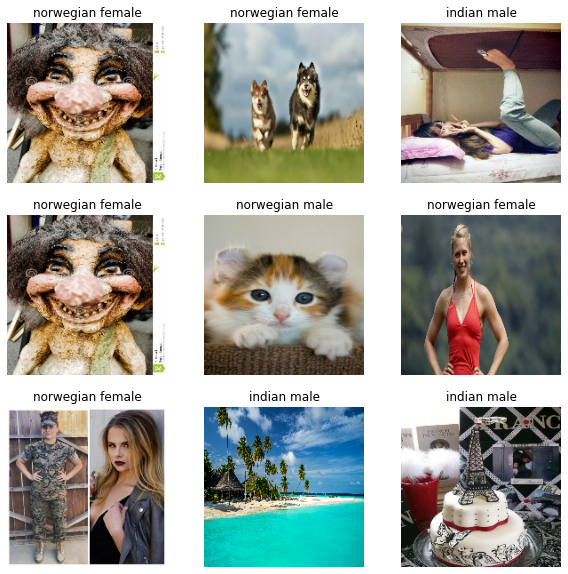

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You can train a model using these datasets by passing them to model.fit.
If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch)
    print(labels_batch)
    print(len(image_batch))
    break

tf.Tensor(
[[[[5.95027771e+01 3.24509239e+01 3.13580185e-01]
   [6.73333359e+01 3.84314804e+01 0.00000000e+00]
   [6.90583344e+01 4.16663589e+01 1.56790003e-01]
   ...
   [1.02452301e+02 1.20844269e+02 1.07236237e+02]
   [1.14214729e+02 1.32390671e+02 1.23959106e+02]
   [1.09887169e+02 1.31534012e+02 1.21109718e+02]]

  [[5.98425941e+01 3.08425941e+01 6.48149149e-03]
   [7.05888901e+01 3.87444420e+01 7.05555439e-01]
   [6.94703674e+01 4.04703674e+01 0.00000000e+00]
   ...
   [1.12133179e+02 1.34381271e+02 1.21715546e+02]
   [1.18511246e+02 1.45177933e+02 1.34650238e+02]
   [1.17997353e+02 1.39763123e+02 1.26599289e+02]]

  [[6.55138855e+01 3.55138855e+01 3.65740746e-01]
   [6.96250000e+01 4.09583282e+01 1.52777636e+00]
   [7.37422867e+01 4.12978363e+01 8.48765254e-01]
   ...
   [1.17157516e+02 1.38290222e+02 1.24072662e+02]
   [1.16824364e+02 1.37277954e+02 1.22217827e+02]
   [9.78548889e+01 1.13495415e+02 1.02134270e+02]]

  ...

  [[2.34937077e+01 3.28146706e+01 2.04627848e+00]
   [3

### Standardize the data

In [23]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0
